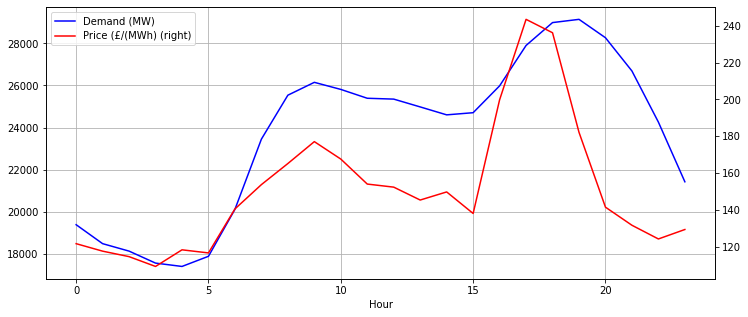

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/avg_price_demand_OCT_NOV_2021.csv")
df.set_index("hour")

plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["Price (pounds/MWh)"].plot(color='red', grid=True, secondary_y=True, label='Price (£/(MWh)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()



<AxesSubplot:>

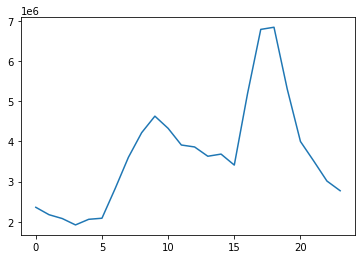

In [2]:
df["price"] = df["Price (pounds/MWh)"] * df["Demand (MW)"]
df["price"].plot()


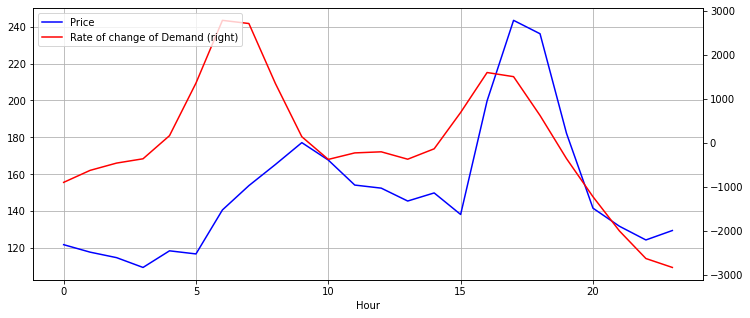

In [3]:
df["demand_grad"] = np.gradient(df["Demand (MW)"])

plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Price (pounds/MWh)"].plot(color='blue', grid=True, label='Price')
ax2 = df["demand_grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Demand')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

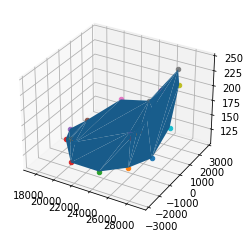

In [4]:
#%matplotlib notebook

from matplotlib import cm
from matplotlib.ticker import LinearLocator

X = df["Demand (MW)"].to_numpy()
Y = df["demand_grad"].to_numpy()
Z = df["Price (pounds/MWh)"].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(X)):
    xs = X[i]
    ys = Y[i]
    zs = Z[i]
    ax.scatter(xs, ys, zs)

ax.plot_trisurf(X, Y, Z)

plt.show()

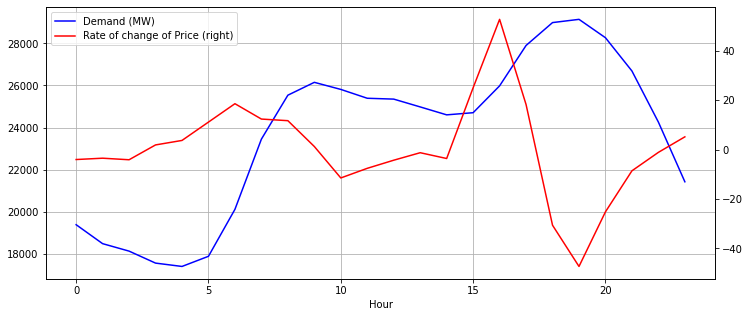

In [5]:
df["grad"] = np.gradient(df["Price (pounds/MWh)"])

plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["grad"].plot(color='red', grid=True, secondary_y=True, label='Rate of change of Price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

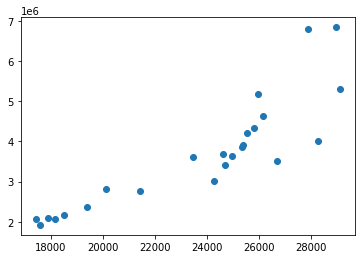

In [6]:
plt.scatter(df["Demand (MW)"], df["price"])

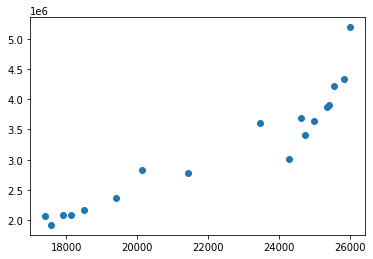

In [7]:
# filter off points which don't fit with the trend
dff = df[df["Demand (MW)"] <= 26000]
plt.scatter(dff["Demand (MW)"], dff["price"])

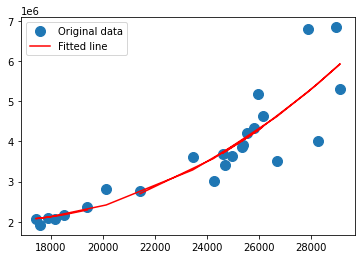

In [8]:
import numpy as np
z = np.polyfit(df["Demand (MW)"], df["price"], 2)

p = np.poly1d(z)

_ = plt.plot(df["Demand (MW)"], df["price"], 'o', label='Original data', markersize=10)
_ = plt.plot(df["Demand (MW)"], df["Demand (MW)"].apply(lambda x: p(x)), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

price = lambda x: p(x)/ x # returns the price per MWh for a given demand

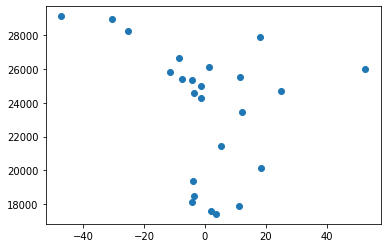

In [9]:
plt.scatter(df["grad"], df["Demand (MW)"])

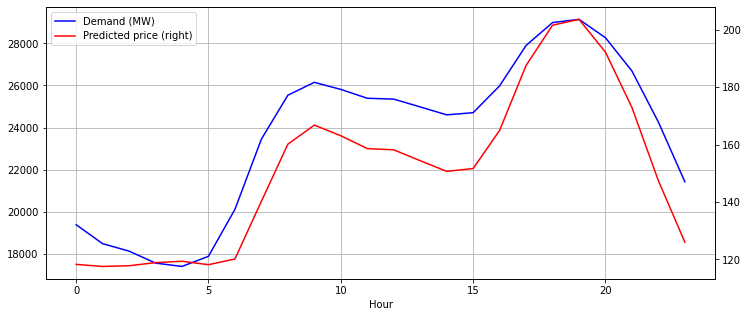

In [10]:
df["predicted_price"] = df["Demand (MW)"].apply(price)
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = df["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = df["predicted_price"].plot(color='red', grid=True, secondary_y=True, label='Predicted price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [11]:
# define constraints
energy_store = 50 # percentage of daily demand stored
charge_rate = 5 # percentage of daily demand charge rate, per hour


In [12]:
dfc = df.copy()

amount = 500 # MW
battery_size = 20 # GW

for i in range(battery_size * int(1000/amount)):
    a = (dfc["demand_grad"] * 1.5) + dfc["Demand (MW)"]
    a.at[0] = a.mean()
    dfc.at[a.idxmax(), "Demand (MW)"] -= amount
    dfc.at[a.idxmin(), "Demand (MW)"] += amount
    dfc["demand_grad"] = np.gradient(dfc["Demand (MW)"])


In [26]:
dfc = df.copy()

amount = 500 # MW
battery_size = 15 # GW
max_charge_rate = 2000 # MW/h

dfc["charge"] = 0

for i in range(battery_size * int(1000/amount)):
    maxh = dfc["Demand (MW)"].idxmax()
    dfc.at[maxh, "Demand (MW)"] -= amount

    a = dfc["Demand (MW)"].sort_values()

    looking = True
    lowest_index = 1
    while looking:
        minh = dfc["Demand (MW)"].nsmallest(lowest_index).index.values[-1]

        if dfc.at[minh, "charge"] >= max_charge_rate:
            lowest_index += 1
        else:
            dfc.at[minh, "Demand (MW)"] += amount
            looking = False
    
    dfc.at[minh, "charge"] += amount
    dfc.at[minh, "Demand (MW)"] += amount


    

In [43]:
dfc = df.copy()

amount = 500 # MW
battery_size = 15 # GW

dfc["charge"] = 0

for i in range(battery_size * int(1000/amount)):
    dfc.at[dfc["Demand (MW)"].idxmax(), "Demand (MW)"] -= amount

    minh = dfc["Demand (MW)"].idxmin()
    dfc.at[minh, "Demand (MW)"] += amount
    dfc.at[minh, "charge"] += amount

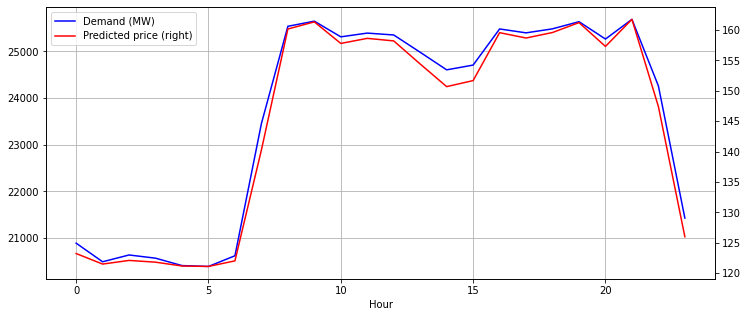

In [44]:


dfc["predicted_price"] = dfc["Demand (MW)"].apply(price)
plt.figure(figsize=(12,5))
plt.xlabel('Hour')
ax1 = dfc["Demand (MW)"].plot(color='blue', grid=True, label='Demand (MW)')
ax2 = dfc["predicted_price"].plot(color='red', grid=True, secondary_y=True, label='Predicted price')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [45]:
dfc["charge"]

0     1500
1     2000
2     2500
3     3000
4     3000
5     2500
6      500
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
Name: charge, dtype: int64